# 🤖 Inframarginality via simulation

❗❗❗ **Make sure to save a copy of this notebook to your Google Drive so your work isn't lost.**

## Introduction

In this tutorial, we'll use `R` to build a simulation of pretrial incarceration and investigate the concept of inframarginality. 

By the end of the tutorial, you'll have foundational understanding of the following:
1. ⛔ Why error rate comparisons suffer from the problem of inframarginality
2. 📈 How to write and plot the results of a simulation using `R`

## ✅ Set up

Make sure to run the cell below. It imports additional useful functions, adjusts `R` settings, and loads in data. 

In [113]:
# Load in additional functions
library(tidyverse)

# Use three digits past the decimal point
options(digits = 3)

# This makes our plots look nice!
theme_set(theme_bw())


## 🏛️ Primer on pretrial incarceration

In the lecture, we talked about how judges have decide whether release or detain defendants who plead "not guilty" to a crime. The actual trial date may be days to years in the future.

> Pretrial detention is a controversial practice. This lab is not intended to condone or condemn the practice.

2️⃣ There are two typical reasons why a judge might choose to detain a defendant: 
1. The judge suspects the defendant will commit a crime if released.
2. The judge thinks the defendant will fail to appear (FTA) at a future required court date.

⬆️ Pretrial incarceration imposes high costs to the community. For example,
- Detained defendants may lose their jobs, and their families may suffer as a result. 
- Pretrial detention is generally much more expensive than community monitoring or check-ins.
- There are large costs associated with severe crimes and having to track down defendants who flee the jurisdiction. Of course, certain types of crime and forgotten court dates tend to be far less costly.

Judges have to weight the costs of detention with the costs of potential violations.

## 🎯 Error rates in pretrial detention decisions

For the purposes of this lab, we define a "pretrial violation" as either committing a crime while released or intentionally failing to appear at a hearing.

> Pretrial violations often include things like forgetting a court date or failing a drug test. For this lab, assume we  only consider severe violations.

It's generally expected that some released defendants will violate the terms of their pretrial release. 

⬇️ Judges try to minimize the rate of violations among released defendants.

> Of course, one way to minimize violations is to detain every defendant. The violation rate is an imperfect metric without more context about the jurisdiction.

## 🚀 Exercise: Constructing risk distributions

For this exercise, consider the following scenario:

- There are two groups, Group 1 and Group 2.
- If everyone in **Group 1** were released, we would observe a **50\% violation rate** for Group 1 defendants.
- For **Group 2**, the corresponding violation rate is **40\%**.

A few additional details about violation probabilities:

- We assume that everyone is either of **high risk** or **low risk**.
- **High risk** defendants, regardless of group membership, violate with a **60\% probability**.
- **Low risk** defendants, regardless of group membership, violate with a **30\% probability**.

Using `R`, determine the proportion of defendants in each group who are low risk.

> Helpful hint: You may find it easier to conceptualize this problem if you assume there are 1,000 individuals in each group, but the answer is the same regardless of the group size.

In [114]:
# Your code here!

# START ANSWER

# If `prop_low_1` is the proportion of Group 1 that is low risk,
# 30% of low risk defendants violate if released,
# 60% of high risk defendants violate if released,
# and 50% of Group 1 violate if released, then

# prop_low_1 * 0.3 + (1 - prop_low_1) * 0.6 = 0.5

# Rearranging:

# prop_low_1 * 0.3 + 0.6 - prop_low_1 * 0.6 = 0.5

# prop_low_1 * (0.3 - 0.6) = (0.5 - 0.6)

prop_low_1 = (0.6 - 0.5) / (0.6 - 0.3)

print("Proportion of Group 1 low risk:")
print(prop_low_1)

# Using the same logic for Group 2:
prop_low_2 = (0.6 - 0.4) / (0.6 - 0.3)

print("Proportion of Group 2 low risk:")
print(prop_low_2)


# END ANSWER

[1] "Proportion of Group 1 low risk:"
[1] 0.333
[1] "Proportion of Group 2 low risk:"
[1] 0.667


## 🎶 Interlude: Functions in `R`

To define a function in `R`, use the following notation:

In [115]:
# Function to add two numbers
add = function(x, y) {
  total = x + y
  return(total)
}

add(100, 150)

[1] 250

🐍 For those more familiar with `Python`, the code above is equivalent to the following:

```
# Function to add two numbers
def add(x, y):
    total = x + y
    return total
```

## 🚀 Exercise: Write a function

Write a function `calc_low_risk_prop` to compute the proportion of defendants in an arbitrary group that are low risk.

Then, use your function to replicate the results of the previous exercise.

Your function should take the following inputs:
- The overall violation rate of the group, `vg`
- The probability of violation for low risk defendants if released, `vl`
- The probability of violation for high risk defendants if released, `vh`

In [116]:
# Your code here!

# START ANSWER

calc_low_risk_prop = function(
    vg, # Group violation rate
    vl, # Pr(violate|low, released)
    vh # Pr(violate|high, released)
  ) {
    low_risk_prop = (vh - vg) / (vh - vl)
    return(low_risk_prop)
  }

print('Prop. low risk Group 1:')
print(calc_low_risk_prop(vg = 0.5, vl = 0.3, vh = 0.6))

print('Prop. low risk Group 2:')
print(calc_low_risk_prop(vg = 0.4, vl = 0.3, vh = 0.6))

# END ANSWER

[1] "Prop. low risk Group 1:"
[1] 0.333
[1] "Prop. low risk Group 2:"
[1] 0.667


## 🤥 False negative rates

Let's consider pretrial detention as a binary decision, where 1 means detain and 0 means release.

By construction: 
- A **false negative (FN)** is the event that a released defendant violates.
- The **false negative rate (FNR)** is the release rate of those who would violate if released.

Intuition for the FNR:

1. The FNR is $\frac{\text{FN}}{\text{FN}+\text{TP}}$ (see slides).
2. $\text{FN}$ is the number of released defendants who violate.
3. $\text{TP}$ is the number of detained defendants who would have violated if released.
2. Therefore, $\text{FN}+\text{TP}$ is the total number of people who would violate if released.
3. So, the FNR is the release rate of those who would violate if released.

> The FNR can also be calculated by interpreting $\text{FN}$ as the *proportion* of released defendants who violate, and $\text{TP}$ as the *proportion* of detained defendants who would have violated if released. This will come in handy later!

## 🧑‍⚖️ Judicial decisions

Let's expand our pretrial detention scenario. Consider the following:
- Suppose there is a judge who can perfectly perceive whether a defendant is low risk or high risk.
- The judge uses a simple decision rule: release low risk defendants, and detain high risk defendants.

In the scenario above, **all defendants are treated identically** (i.e., irrespective of group membership).

## 🚀 Exercise: Comparing false negative rates

For the judge described above, write a function to calculate to the calculate the false negative rate for an arbitrary group with an overall violation rate of `vg`, where low risk defendants violate with probability `vl` and high risk defendants violate with probability `vb`.

> Your `calc_low_risk_prop` function may come in handy.

Then, calculate the expected false negative rate for each group.

> Important aside: It's impossible to calculate the true FNR from real data, since we do not observe violations for defendants who are detained. We can only estimate the true FNR under strong assumptions. 
>
> For this problem, we're taking the perspective of a statistical **oracle** who knows everything about the populations of interest.

What do you take away from your results? 

In [117]:
# Your code here!

# START ANSWER

calc_fnr = function(vg, vl, vh) {
  
  # First, get the proportion of the group that is low risk.
  pl = calc_low_risk_prop(vg, vl, vh)
  
  # Then, get the proportion of the group that is high risk.
  ph = 1 - pl
  
  # Next, get the proportion of the group that is a FN (i.e., released+violate)
  p_fn = pl*vl
  
  # And the proportion that is a TP (i.e., detained+violate)
  p_tp = ph*vh
  
  # Finally, calculate the FNR
  fnr = p_fn / (p_fn + p_tp)
  
  return(fnr)
  
}

print('Group 1 FNR:')
print(calc_fnr(0.5, 0.3, 0.6))

print('Group 2 FNR:')
print(calc_fnr(0.4, 0.3, 0.6))

# The FNRs are different, even though the decision rule is fair.
# Differences in error rates can falsely suggest discriminatory behavior.

# END ANSWER

[1] "Group 1 FNR:"
[1] 0.2
[1] "Group 2 FNR:"
[1] 0.5


## 🎶 Interlude: Vectors and `for` loops in `R`

A **vector** in `R` is a list of numbers, strings, or booleans.

> Not to be confused with a **list**, which is not covered in this tutorial. Lists can contain elements of any type.

Here's a shortcut for making a vector of arbitrary length with a constant value:

In [118]:
# NA is similar to None in Python
rep(NA, 10)

[1] NA NA NA NA NA NA NA NA NA NA

We can also use `c()` to create vectors.

> 🔎 The "c" in `c()` stands for **concatenate**.


In [119]:
c(10, 100, 1000)

[1]   10  100 1000

We can extract **elements** from vectors using their **index**, or their place in line.

> 🔎 Unlike most other programming languages, `R` is 1-indexed, not 0-indexed. So, the first element in a vector `v` is `v[1]`, not `v[0]`.

In [120]:
my_vector = c(10, 100, 1000)
my_vector[1]

[1] 10

#### 🔎 Printing vectors 

If you explicitly `print` a vector, the output looks a little different:

In [121]:
print(my_vector)

[1]   10  100 1000


Why is there a `[1]` on the left of the printed results? 

Printing a longer vector gives us a hint:

In [122]:
print(25:75)

 [1] 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
[26] 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
[51] 75


The bracketed numbers on the left side of the printed results indicate the index of the element immediately to the right.

For example `[26]` indicates that `50` is the 26th element in the vector.

### `for` loops

For most data science projects, `for` loops should be avoided in favor of more efficient tools.

> For example, the `map` function and its variants from `furrr` package. Run `?map` for details.

However, for exposition, here's the `R` syntax for a `for` loop:

In [123]:
# Print the odd numbers between 1 and 20
for (i in seq(1, 20, 2)) {
  print(i)
}

[1] 1
[1] 3
[1] 5
[1] 7
[1] 9
[1] 11
[1] 13
[1] 15
[1] 17
[1] 19


🐍 The equivalent in `Python`:

```
# Print the odd numbers between 1 and 20
for i in range(1, 20, 2):
    print(i)
```

## 🚀 Exercise: Simulating different scenarios

For this exercise, we'll investigate how our results change as a function of the violation probabilities of low and high risk defendants.

As above, assume that the overall violation rate of Group 1 is 50\%, and 40\% for Group 2.

Use two nested `for` loops to iterate over the following two vectors:

1. `vl_vals = seq(0, 0.3, by=0.001)`

> These are possible values of the probability that a low risk defendant violates.

2. `vh_vals = c(0.6, 1, by=0.001)`

> These are possible values of the probability that a high risk defendant violates.

At each iteration, calculate the difference in false negative rates between Groups 1 and 2. Call this value `diff`.

Make sure to create three vectors to store the values of `vl`, `vh`, and `diff` at each iteration. 

> You should initialize each of these vectors with `rep(NA, N)`, where `N` is the total number of iterations. This is faster than concatenating to the end of the results vector at each iteration.
>
> You can use the `summary` function on the results vectors to check if the values make sense. 

In the next exercise, we'll plot the results from this exercise.

In [124]:
# Your code here!

# START ANSWER

vl_vals = seq(0, 0.3, by=0.001)
vh_vals = seq(0.6, 1, by=0.001)

n_iterations = length(vl_vals) * length(vh_vals)

vl_results = rep(NA, n_iterations)
vh_results = rep(NA, n_iterations)
diff_results = rep(NA, n_iterations)

counter = 1

for (vl in vl_vals) {
  for (vh in vh_vals) {

    fnr1 = calc_fnr(vg=0.5, vl, vh)
    fnr2 = calc_fnr(vg=0.4, vl, vh)
    diff = fnr1 - fnr2

    vl_results[counter] = vl
    vh_results[counter] = vh
    diff_results[counter] = diff

    counter = counter + 1
  }
}


# It looks like our answers are constrained between -1 and 0
summary(diff_results)

# END ANSWER

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.3000 -0.1577 -0.0927 -0.1026 -0.0413  0.0000 

## 🚀 Final exercise: Plotting the results

Create a tibble (i.e., dataframe with extra features) with your three results vectors from the previous exercise. 

Using your tibble, make a plot using `geom_raster`.

> `?geom_raster` for more details!

Using `geom_raster`, put the `vl` results on the x-axis, the `vh` results on the y-axis, and map `fill` (not `color`!) to `diff`. 

What patterns do you notice? How do these relate to the FNR formula?

🖼️ Here's how to make a tibble:

In [125]:
# colon `:` is a shortcut for vectors of consecutive integers
x = 1:5
y = 6:10

# df is often used to denote a dataframe
df = tibble(
  x_vals = x,
  y_vals = y
)

df

x_vals,y_vals
<int>,<int>
1,6
2,7
3,8
4,9
5,10


vl,vh,diff
<dbl>,<dbl>,<dbl>
0.002,0.649,-0.00100
0.083,0.757,-0.04661
0.002,0.854,-0.00100
0.075,0.931,-0.04079
0.161,0.949,-0.09695
0.005,0.868,-0.00251
0.250,0.930,-0.17096
0.280,0.741,-0.22503
0.116,0.645,-0.07072


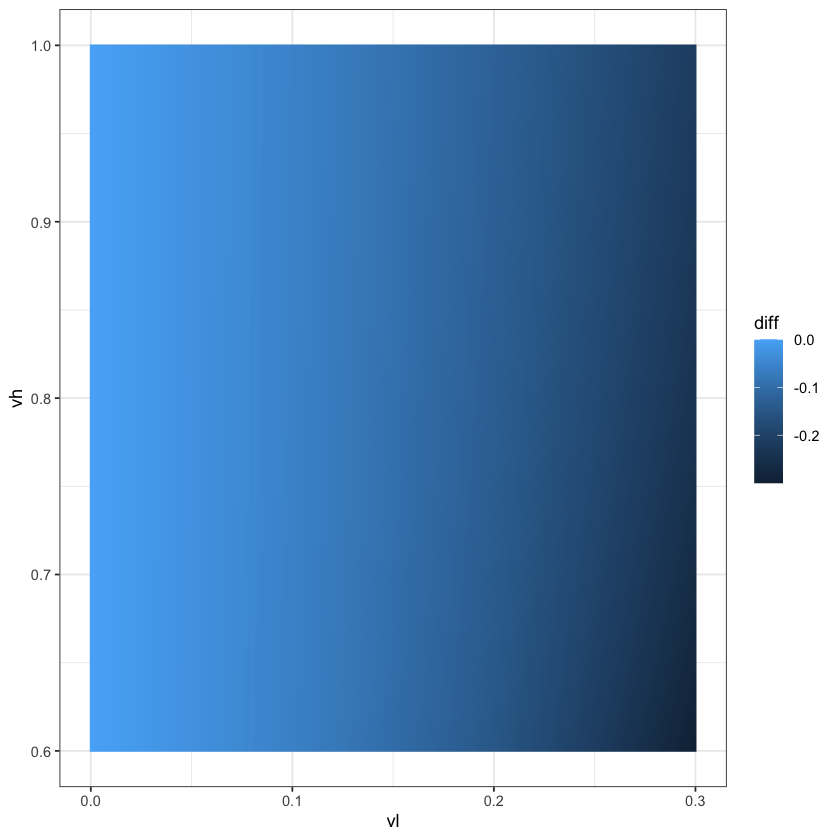

In [127]:
# Your code here!

# START ANSWER

df = tibble(
  vl = vl_results,
  vh = vh_results,
  diff = diff_results
)

# 10 random rows
sample_n(df, 10)

df %>%
  ggplot() +
  geom_raster(aes(x=vl, y=vh, fill=diff))

# As the violation probability of low risk defendants moves toward 0,
# the difference in false negative rates becomes less severe, eventually
# reaching 0.

# However, the same is not quite true for the violation probability of
# high risk defendants. As the violation probability moves closer to 1,
# the difference in false negative rates becomes slightly less severe,
# but not nearly to the same extent as the changes observed
# when low risk violation probability decreases

# Mathematical intuition: the FNR formula is FN/(FN+TP).
# If low risk defendants rarely violate and are always released, then
# the numerator will be close to 0. 
# If high risk defendants are more likely to violate, then TP will increase
# and FNR will decrease, but not nearly with the same effect as decreasing FN.

# END ANSWER